<a href="https://colab.research.google.com/github/wahyunh10/Banking-Deposit-Target-Prediction/blob/main/Banking_Deposit_Target_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Package**

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
# import library
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn import under_sampling, over_sampling

from sklearn.model_selection import train_test_split

from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import  LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import kneighbors_graph
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# **Dataset**

In [3]:
df = pd.read_csv('train.csv', sep=';')
df.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
22942,51,management,divorced,secondary,no,292,no,no,cellular,26,aug,146,9,-1,0,unknown,no
14118,35,services,single,primary,no,167,no,yes,cellular,11,jul,614,2,-1,0,unknown,yes
5496,32,self-employed,single,secondary,no,4,yes,no,unknown,23,may,233,2,-1,0,unknown,no
37184,33,management,married,tertiary,no,1064,yes,no,cellular,13,may,562,1,-1,0,unknown,yes
38142,60,retired,divorced,secondary,no,496,yes,no,cellular,15,may,655,2,-1,0,unknown,yes
1749,27,self-employed,single,secondary,no,78,yes,no,unknown,9,may,825,1,-1,0,unknown,no
11967,42,self-employed,married,tertiary,no,1430,yes,yes,unknown,20,jun,16,3,-1,0,unknown,no
59,46,services,married,primary,no,179,yes,no,unknown,5,may,1778,1,-1,0,unknown,no
15226,34,unemployed,married,secondary,no,2126,yes,no,cellular,17,jul,215,2,-1,0,unknown,no
18955,54,management,married,tertiary,no,11391,no,no,cellular,4,aug,333,1,-1,0,unknown,no


# **Exploratory Data Analysis (EDA)**

**Descriptive Statistic**

In [4]:
# melihat info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
# cek data duplikat
df.duplicated().any()

False

In [6]:
# cek data null
df.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

Observation :
1. Dataset terdiri dari 17 kolom dan 45211 baris
2. Terdapat 7 data numerikal dan 10 data kategorikal
3. Dari hasil pengecekan, tidak ada issue yang mencolok pada tipe data untuk setiap kolom (tipe data sudah sesuai)
4. Tidak terdapat missing values, tetapi terdapat unknown values pada beberapa feature
5. Dataset tidak terdapat data yang duplikat
6. Terdapat beberapa fitur yang bertipe categorical sehingga harus dilakukan label encoding/one-hot encoding/feature hashing
7. Kolom yang akan menjadi feature target adalah kolom y


In [7]:
# split kolom numerical dan kolom categorical
num_cols = df.select_dtypes('number').columns.tolist()
cat_cols = df.select_dtypes('object').columns.tolist()
print(num_cols)
print(cat_cols)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [8]:
# melihat deskripsi kolom numerical
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [9]:
# melihat hubungan kolom previous dan pdays
df[(df['previous'] == 0) & (df['pdays'] == -1)].shape[0]

36954

In [10]:
# melihat kolom balance negatif
df[df['balance'] < 0].shape[0]

3766

In [11]:
# melihat jumlah data dengan balance negatid dan y yes
df[(df.y == 'yes') & (df.balance < 0)].shape[0]

210

In [12]:
# melihat data previous
df[(df.previous) > 30]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
26668,51,entrepreneur,married,secondary,no,653,yes,no,cellular,20,nov,16,9,112,37,other,no
28498,49,management,single,tertiary,no,145,yes,no,cellular,29,jan,57,2,248,38,failure,no
28886,31,management,single,tertiary,no,358,yes,no,cellular,30,jan,68,3,256,51,failure,no
29182,40,management,married,tertiary,no,543,yes,no,cellular,2,feb,349,2,262,275,other,no
37567,39,management,married,tertiary,no,0,yes,no,cellular,14,may,11,15,261,38,failure,no
38326,46,blue-collar,married,primary,no,1085,yes,yes,cellular,15,may,523,2,353,58,other,yes
39141,44,admin.,married,secondary,no,429,yes,yes,cellular,18,may,35,3,349,32,failure,no
42422,27,student,single,secondary,no,91,no,no,telephone,4,dec,157,6,95,37,other,no
42611,35,technician,single,secondary,no,4645,yes,no,cellular,11,jan,502,3,270,40,other,no
44089,37,technician,married,secondary,no,432,yes,no,cellular,6,jul,386,3,776,55,failure,yes


Dari hasil inspeksi di atas, beberapa insight yang dapat diambil adalah:

* Kolom `age` sepertinya berdistribusi normal karena memiliki nilai mean dan median yang berdekatan
* Kolom lain memiliki mean yang cukup jauh dari median, yang berarti distribusinya tidak mendekati normal
* Kolom `pdays` menunjukkan jumlah hari yang yang telah berlalu setelah customer dihubungi pada campaign sebelumnya.
* Kolom `balance` memiliki nilai negatif sebanyak 3766, tetapi nilainya masih masuk akal
* Kolom `previous` (jumlah kontak yang dilakukan pada campaign sebelumnya) memiliki nilai maksimum yang sangat tinggi, yaitu 275 (indikasi sebagai outlier)
* Data dengan `pdays` = -1 pasti nilai `previous` = 0, dan data ini tampak mendominasi
* Perlu dilakukan rescaling pada masing-masing kolom

In [13]:
# melihat deskripsi kolom categorical
df[cat_cols].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [14]:
# melihat detail jumlah masing-masing kolom 
for col in cat_cols:
    print(f'Value count kolom {col};')
    print(df[col].value_counts())
    print()

Value count kolom job;
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

Value count kolom marital;
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

Value count kolom education;
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

Value count kolom default;
no     44396
yes      815
Name: default, dtype: int64

Value count kolom housing;
yes    25130
no     20081
Name: housing, dtype: int64

Value count kolom loan;
no     37967
yes     7244
Name: loan, dtype: int64

Value count kolom contact;
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

Value count kolom month;
may    13766
jul     6895
aug     6247
jun     5341
nov     3970

In [17]:
# menghitung CVR 
count_yes = df[df.y == 'yes'].shape[0]
count_all = df.shape[0]

CVR = round(count_yes / count_all * 100, 2)
CVR

11.7

Beberapa insight yang bisa diambil:

* Terdapat data unknown yang cukup banyak, terutama pada kolom `job`, `education`, `contact` dan `poutcome`
* Tampak frekuensi yang imbalance dari kolom `martial`, `education`,`default`, `loan`, `contact`, `poutcome` dan `y`
* 98% customers tidak gagal bayar (`default`)
* Lebih dari 80% customers tidak memiliki utang (`loan`)
* Kolom `martial` didominasi (proporsi lebih dari 50%) oleh customers dengan status married
* Tipe kolom `default`, `housing`, `loan`, `y` dapat diubah menjadi boolean/binary
* Nilai CVR sebesar 11.7%

[QUESTION]

1. Apakah ada kolom dengan tipe data kurang sesuai?

  **Tidak ada. Semua kolom sudah memiliki tipe data yang sesuai.**

2. Apakah ada kolom yang memiliki nilai kosong (missing values)? Jika ada, apa saja?

  **Tidak ada kolom yang memiliki nilai kosong. Ada beberapa kolom yang memiliki 'unknown' values, yaitu kolom `job`, `education`, `contact`, dan `poutcome`. Kami memilih untuk tidak mengubahnya untuk menghindari adanya bias pada data apabila unknown value-nya diubah menjadi value lain.**

3. Apakah ada kolom yang isi nilainya tidak sesuai?

  **Kolom `balance` dan `pdays` memiliki nilai negatif. Untuk nilai `balance` yang negatif, sepertinya tidak ada masalah. Kami mengasumsikan customer memiliki hutang pada tabungannya. Nilai `pdays` (previous day) = -1 menunjukkan bahwa customer tidak dihubungi pada campaign sebelumnya. Ada kemungkinan kami mengubah nilainya menjadi 999 yang mewakili durasi hari yang sangat lama.**

4. Apakah ada kolom yang memiliki nilai summary agak aneh?

  **Beberapa kolom memiliki mean yang cukup jauh dari median, yang berarti distribusinya tidak mendekati normal. Kolom-kolom ini adalah `age`, `balance`, `campaign`, `duration`, `pdays`, dan `previous`. Kolom `balance`, `duration`, `pdays`, `previous` juga memiliki nilai maksimal yang jauh dari median.**

# **Unicariate Analysis**

**Numerical**

**Boxplot**

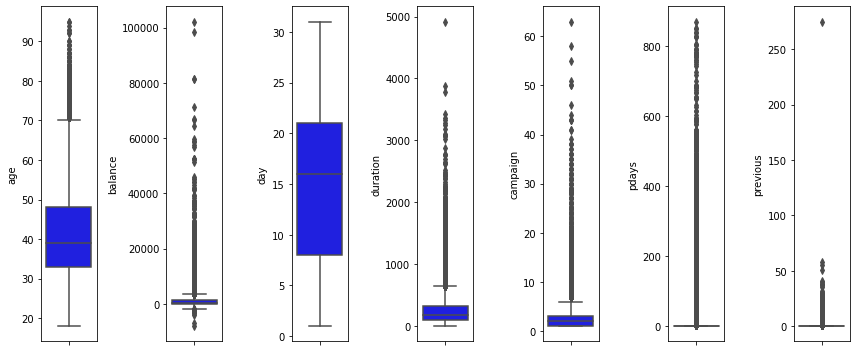

In [18]:
plt.figure(figsize=(12, 5))
for i in range(len(num_cols)):
    plt.subplot(1,7,i+1)
    sns.boxplot(y = df[num_cols[i]], color = 'blue', orient = 'v')
    plt.tight_layout()

**Violin Plot**

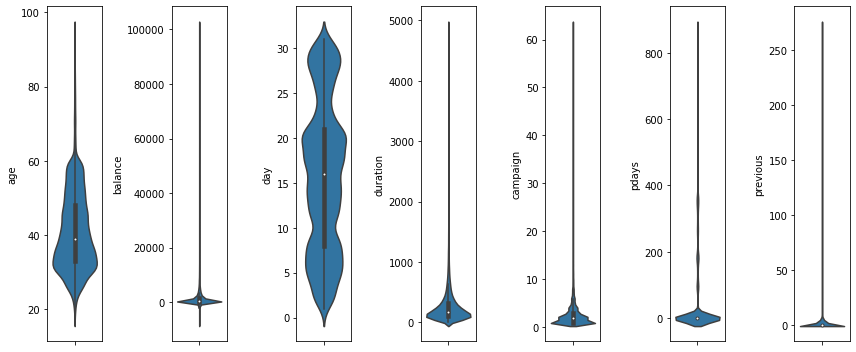

In [20]:
plt.figure(figsize = (12,5))
for i in range(len(num_cols)):
    plt.subplot(1, 7, i+1)
    sns.violinplot(y = df[num_cols[i]])
    plt.tight_layout()

**Dist Plot**

* **Highly Skewed** : Jika `skewness < -1` atau `skewness > 1`
* **Moderately Skewed** : Jika `-1 < skewness < -0.5` atau `0.5 < skewness <  1`
* **Normal/Mendekati Normal Skewed** : Jika `-0.5 < skewness < 0.5` 

In [21]:
# melihat nilai skew kolom numerical
df_skew = df[num_cols].skew()
df_skew

age          0.684818
balance      8.360308
day          0.093079
duration     3.144318
campaign     4.898650
pdays        2.615715
previous    41.846454
dtype: float64

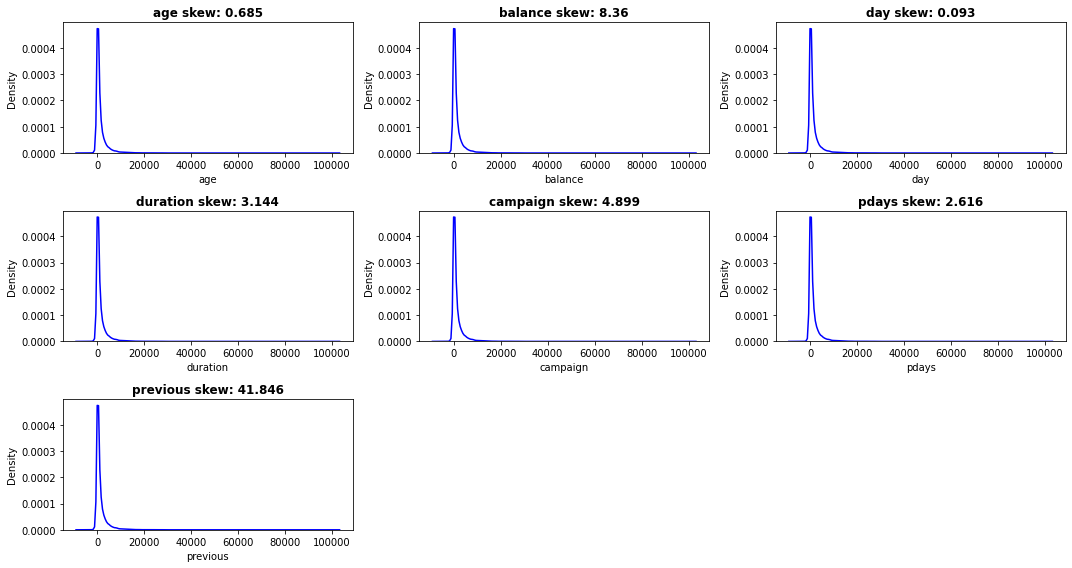

In [23]:
features = num_cols
plt.figure(figsize=(15, 8))

for i in range(0, len(features)):
    plt.subplot(3, len(features)/2, i+1)
    sns.kdeplot(x=df[features[1]], color = 'blue')
    plt.xlabel(features[i])
    plt.title(features[i] + ' skew: ' + str(round(df_skew[features[i]], 3)), fontsize = 12, fontweight = 'bold')
    plt.tight_layout()

HASIL OBSERVASI

Beberapa insight yang bisa diambil:

* Semua kolom memiliki outlier, tetapi outlier utamanya terlihat pada kolom `balance`, `duration`, `campaign`, dan `previous`
* Tampak semua kolom memiliki distribusi yang skewed, kecuali kolom `day`
* Kolom `day` yang merupakan kolom tanggal, sehingga tidak perlu terlalu diperhatikan bentuk distribusinya


**To do:**

* Outliers handling
* Melakukan transformasi untuk kolom yang sangat-sangat skewed